In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
train = pd.read_excel('Training_dataset.xlsx')
train = train.drop('Additional Condition', axis=1)
train.head()

,Message,Label
0,I want to activate my credit card,activate_card_0
1,I don't know how to activate my card,activate_card_0
2,I want to activate my card,activate_card_0
3,Why is your activation process not working ?,activate_card_0
4,My bank card is not active,activate_card_0


In [ ]:
train.Label.unique()

array(['card_stop_0', 'contactless_0', 'get_card_limit_0',
       'get_transaction_info_0', 'info_abroad_0',
       'info_card_expiration_0', 'info_card_number_0',
       'info_card_types_credit_0', 'info_charges_abroad_0',
       'info_CVC_CVV_0', 'lost_card_0', 'modify_limit_0',
       'new_card_reader_0', 'new_pin_0', 'order_card_0d_extra',
       'order_card_0', 'pin_by_sms_0', 'unblock_card_0',
       'use_abroad_0a_credit', 'use_abroad_0b_debit', 'use_abroad_0',
       'use_abroad_0e_europe', 'use_abroad_0f_non_europe'], dtype=object)

In [ ]:
train.shape

(889, 2)

In [ ]:
valid = pd.read_csv('Validation dataset.csv',delimiter=';')
valid.head()

,Message,Label
0,I want to use my card in Japan,use_abroad_0f_non_europe
1,Activate card abroad,use_abroad_0
2,I want to use my card in Portugal,use_abroad_0e_europe
3,I want to use my debit card abroad,use_abroad_0b_debit
4,i want to use my credit card in France,use_abroad_0a_credit


In [ ]:
valid.shape

(439, 2)

In [ ]:
test = valid[:39]
valid = valid[39:]

In [ ]:
test.tail()

,Message,Label
34,How can I unlock my card for abroad?,use_abroad_0
35,Can I get an overview of all my cards?,cards_overview_0
36,Can you activate my card abroad?,use_abroad_0
37,I have lost my bank card,lost_card_0
38,how can I get a new card ?,order_card_0


In [ ]:
train.shape

(889, 2)

In [ ]:
test.head()

,Message,Label
0,I want to use my card in Japan,use_abroad_0f_non_europe
1,Activate card abroad,use_abroad_0
2,I want to use my card in Portugal,use_abroad_0e_europe
3,I want to use my debit card abroad,use_abroad_0b_debit
4,i want to use my credit card in France,use_abroad_0a_credit


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


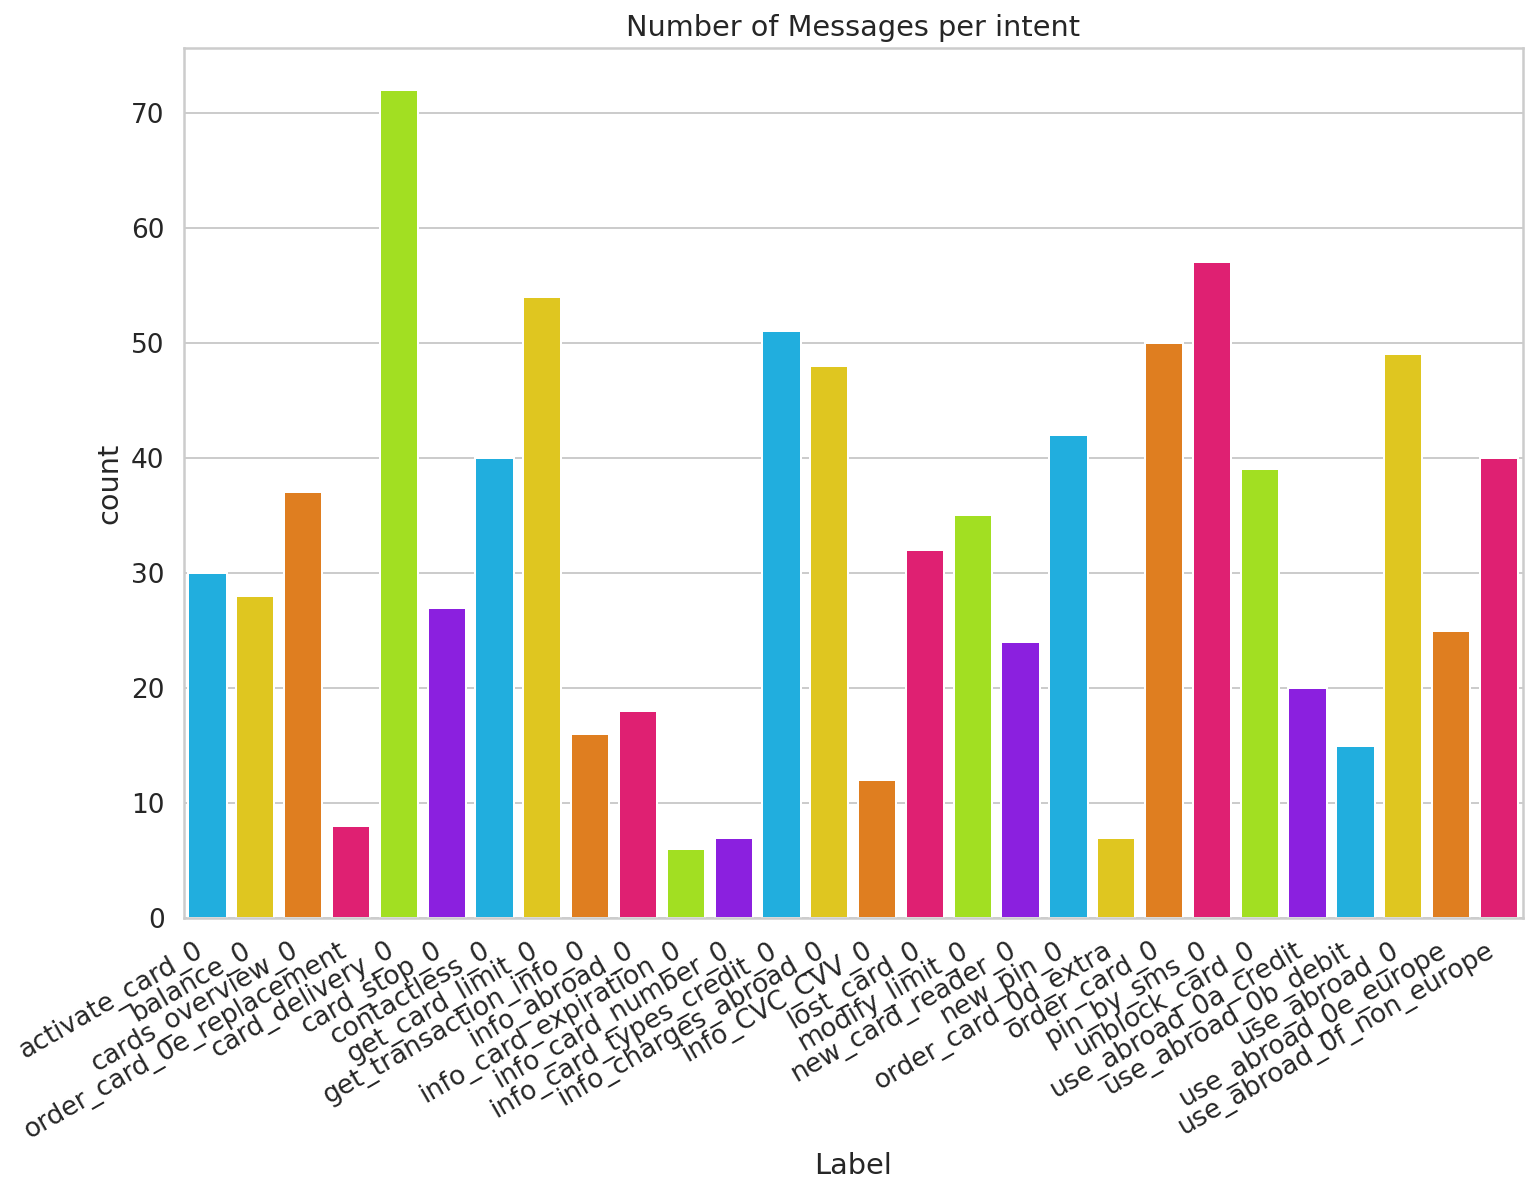

In [ ]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of Messages per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
# BERT Download

In [ ]:
import pandas as pd
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"



In [ ]:
train = pd.read_excel('Training_dataset.xlsx')
train = train.drop('Additional Condition', axis=1)
train.head()

,Message,Label
0,I want to activate my credit card,activate_card_0
1,I don't know how to activate my card,activate_card_0
2,I want to activate my card,activate_card_0
3,Why is your activation process not working ?,activate_card_0
4,My bank card is not active,activate_card_0


In [ ]:
test = pd.read_csv('Validation dataset.csv',delimiter=';')
test.head()

,Message,Label
0,I want to use my card in Japan,use_abroad_0f_non_europe
1,Activate card abroad,use_abroad_0
2,I want to use my card in Portugal,use_abroad_0e_europe
3,I want to use my debit card abroad,use_abroad_0b_debit
4,i want to use my credit card in France,use_abroad_0a_credit


In [ ]:
train.Label.value_counts()

card_delivery_0              72
pin_by_sms_0                 57
get_card_limit_0             54
info_card_types_credit_0     51
order_card_0                 50
use_abroad_0                 49
info_charges_abroad_0        48
new_pin_0                    42
use_abroad_0f_non_europe     40
contactless_0                40
unblock_card_0               39
cards_overview_0             37
modify_limit_0               35
lost_card_0                  32
activate_card_0              30
balance_0                    28
card_stop_0                  27
use_abroad_0e_europe         25
new_card_reader_0            24
use_abroad_0a_credit         20
info_abroad_0                18
get_transaction_info_0       16
use_abroad_0b_debit          15
info_CVC_CVV_0               12
order_card_0e_replacement     8
info_card_number_0            7
order_card_0d_extra           7
info_card_expiration_0        6
Name: Label, dtype: int64

In [ ]:
len(train.Label.unique())

28

In [ ]:
test.Label.value_counts()

use_abroad_0                 49
card_delivery_0              44
new_pin_0                    39
unblock_card_0               34
use_abroad_0f_non_europe     28
order_card_0                 28
modify_limit_0               27
activate_card_0              20
cards_overview_0             19
order_card_0e_replacement    17
info_charges_abroad_0        13
lost_card_0                  13
card_stop_0                  13
get_card_limit_0             12
use_abroad_0a_credit         10
balance_0                     9
contactless_0                 9
pin_by_sms_0                  8
new_card_reader_0             8
use_abroad_0b_debit           7
use_abroad_0e_europe          6
info_card_number_0            5
inactive_card_0               4
get_transaction_info_0        3
order_card_0d_extra           3
info_CVC_CVV_0                3
info_abroad_0                 3
info_card_expiration_0        3
info_card_types_credit_0      2
Name: Label, dtype: int64

In [ ]:
# train = train.drop('Label', axis=1)
# test = test.drop('Label', axis=1)

train.head()

,Message,Label
0,I want to activate my credit card,activate_card_0
1,I don't know how to activate my card,activate_card_0
2,I want to activate my card,activate_card_0
3,Why is your activation process not working ?,activate_card_0
4,My bank card is not active,activate_card_0


In [ ]:
trainfeatures=train.copy()
trainlabels=trainfeatures.pop("Label")
trainfeatures=trainfeatures.values

In [ ]:
validfeatures=test.copy()
validlabels=validfeatures.pop("Label")

# testfeatures=testfeatures.values
validfeatures=validfeatures.values
validlabels = validlabels[30:]
validfeatures = validfeatures[30:]

testlabels = validlabels[:30]
testfeatures = validfeatures[:30]

from sklearn.preprocessing import LabelBinarizer
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)

testlabels=binarizer.transform(testlabels.values)
validlabels=binarizer.transform(validlabels.values)

In [ ]:
len(binarizer.classes_)

27

In [ ]:
import pickle

with open('labels.pkl', 'wb') as f:
    pickle.dump(binarizer, f)
    

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
trainfeatures[0]

array(['does my account have money on it?'], dtype=object)

In [ ]:
text_test = trainfeatures[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2515 2026 4070 2031 2769 2006 2009 1029  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.27456704 -0.14935182 -0.9999792   0.18091269 -0.03016882 -0.03264466
 -0.97656405  0.06366078  0.42134345 -0.16334268 -0.94552845  0.29968354]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.00408385  0.64257336  0.5607903  ... -0.6532629   0.09762695
   0.10499702]
 [-0.518692   -0.8298529   0.19397123 ...  0.10638388 -0.23115842
  -1.1876835 ]
 [ 0.23598471 -0.27040452  0.38544732 ... -0.41297153  0.21481837
   0.3367436 ]
 ...
 [ 0.08231564 -0.01779179  0.3929171  ... -1.145096    0.16365322
  -0.43860212]
 [ 0.17705272  0.05057101  0.4548288  ... -0.17781582 -0.1427348
  -0.22986679]
 [ 0.04935445  0.0584518   0.3129231  ... -0.10187594  0.01084978
  -0.04104552]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(27, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(trainfeatures[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.08251558 0.06188807 0.02196505 0.03707336 0.06898576 0.02450348
  0.01633797 0.00766539 0.01082793 0.02701944 0.01477729 0.01914726
  0.0402455  0.09143461 0.00717777 0.03239705 0.13457917 0.02289622
  0.03917007 0.00797778 0.01383809 0.10946984 0.02505923 0.02135914
  0.00838838 0.03966751 0.01363301]], shape=(1, 27), dtype=float32)


In [ ]:
classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
epochs=10
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
trainlabels.shape

(859, 27)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=trainfeatures,y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/10
27/27 [==============================] - 507s 18s/step - loss: 3.3136 - categorical_accuracy: 0.0664 - val_loss: 2.8943 - val_categorical_accuracy: 0.1093
Epoch 2/10
27/27 [==============================] - 503s 19s/step - loss: 2.9354 - categorical_accuracy: 0.1804 - val_loss: 2.6420 - val_categorical_accuracy: 0.2187
Epoch 3/10
27/27 [==============================] - 517s 19s/step - loss: 2.6097 - categorical_accuracy: 0.3155 - val_loss: 2.3340 - val_categorical_accuracy: 0.3440
Epoch 4/10
27/27 [==============================] - 550s 21s/step - loss: 2.2340 - categorical_accuracy: 0.4249 - val_loss: 2.0087 - val_categorical_accuracy: 0.4305
Epoch 5/10
27/27 [==============================] - 505s 19s/step - loss: 1.8993 - categorical_accuracy: 0.5576 - val_loss: 1.7433 - val_categorical_accuracy: 0.5080
Epoch 6/10
27/27 [==============================] - 505s 19s/step - loss: 1.60

In [ ]:
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 7s 7s/step - loss: 0.7292 - categorical_accuracy: 0.9000
Loss: 0.7291965484619141
Accuracy: 0.8999999761581421


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


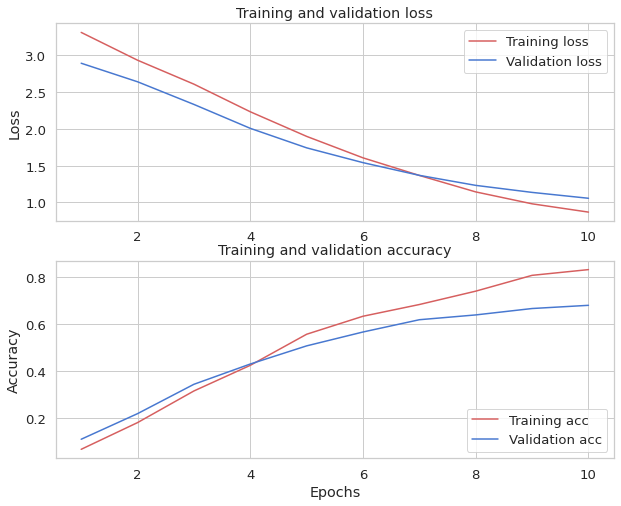

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : estimated intent: {results[i]}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'my card is blocked',  # this is the same sentence tried earlier
    'How can my card be activated abroad',
    'Can i Get an update on the delivery status',
    'How much does it cost to withdraw money from ATM in the Amsterdam?',
    'I think my card is blocked'
]

results = tf.nn.softmax(classifier_model(tf.constant(examples)))

In [ ]:
binarizer.classes_

array(['balance_0', 'card_delivery_0', 'card_stop_0', 'cards_overview_0',
       'contactless_0', 'get_card_limit_0', 'get_transaction_info_0',
       'info_CVC_CVV_0', 'info_abroad_0', 'info_card_expiration_0',
       'info_card_number_0', 'info_card_types_credit_0',
       'info_charges_abroad_0', 'lost_card_0', 'modify_limit_0',
       'new_card_reader_0', 'new_pin_0', 'order_card_0',
       'order_card_0d_extra', 'order_card_0e_replacement', 'pin_by_sms_0',
       'unblock_card_0', 'use_abroad_0', 'use_abroad_0a_credit',
       'use_abroad_0b_debit', 'use_abroad_0e_europe',
       'use_abroad_0f_non_europe'], dtype='<U25')

In [ ]:
len(binarizer.classes_)

27

In [ ]:
import pickle

with open('labels.pkl', 'wb') as f:
    pickle.dump(lb, f)
    

In [ ]:
intents=binarizer.inverse_transform(results.numpy())

In [ ]:
intents

array(['unblock_card_0', 'use_abroad_0', 'card_delivery_0',
       'info_charges_abroad_0', 'unblock_card_0'], dtype='<U25')

In [ ]:
print_my_examples(examples, intents)

input: my card is blocked             : estimated intent: unblock_card_0
input: How can my card be activated abroad : estimated intent: use_abroad_0
input: Can i Get an update on the delivery status : estimated intent: card_delivery_0
input: How much does it cost to withdraw money from ATM in the Amsterdam? : estimated intent: info_charges_abroad_0
input: I think my card is blocked     : estimated intent: unblock_card_0



In [ ]:
classifier_model.save('saved_model/my_model')

In [ ]:
!zip -r saved_model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/assets/vocab.txt (deflated 53%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.index (deflated 81%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 31%)
  adding: saved_model/my_model/saved_model.pb (deflated 93%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 84%)


In [ ]:
classifier_model.save('my_model.h5')

In [ ]:
!unzip /content/saved_model.zip 

Archive:  /content/saved_model.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/saved_model.zip or
        /content/saved_model.zip.zip, and cannot find /content/saved_model.zip.ZIP, period.


In [ ]:
!pip install fastapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 80 kB 8.0 MB/s 


In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 4.9 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=863e02101df8c1c227d6906ef398215b0ec739895013b740a639251eca052f62
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [78]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn
from fastapi import FastAPI
# import tf
import tensorflow as tf

app = FastAPI()

@app.get("/")
async def root():
    return {"message": "Welcome to the Intent API!"}


@app.post("/predict")
async def get_intent_prediction(message: str = ""):
    if message == "":
        return {"message": "No message provided"}
    
    
    intent_model = tf.keras.models.load_model('saved_model/my_model')
    print(intent_model)
    file = open("labels.pkl",'rb')
    binarizer = pickle.load(file)
    print(binarizer)

    results = tf.nn.softmax(intent_model(tf.constant([message])))
    intents = binarizer.inverse_transform(results.numpy())



    return {
        "message": message,
        "model-prediction": intents[0]
    }


ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

Public URL: http://484a-34-133-246-147.ngrok.io


INFO:     Started server process [347]
INFO:uvicorn.error:Started server process [347]
INFO:     Waiting for application startup.
INFO:uvicorn.error:Waiting for application startup.
INFO:     Application startup complete.
INFO:uvicorn.error:Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:uvicorn.error:Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


LabelBinarizer()
INFO:     102.89.33.52:0 - "POST /predict?message=%22im%20abroad%20and%20card%20not%20working%22 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:uvicorn.error:Shutting down
INFO:     Waiting for application shutdown.
INFO:uvicorn.error:Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:uvicorn.error:Application shutdown complete.
INFO:     Finished server process [347]
INFO:uvicorn.error:Finished server process [347]


In [ ]:
intent_model = tf.keras.models.load_model('saved_model/my_model')
file = open("labels.pkl",'rb')
binarizer = pickle.load(file)

results = tf.nn.softmax(intent_model(tf.constant("my card is not working")))
intents = binarizer.inverse_transform(results.numpy())

NameError: ignored